# The CNN Model 

## Import necessary packages




In [0]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from keras.utils import plot_model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
import matplotlib.pyplot as plt
import functools
from keras import backend as K
from skimage import io

import os
import cv2
import gc
import time

Using TensorFlow backend.


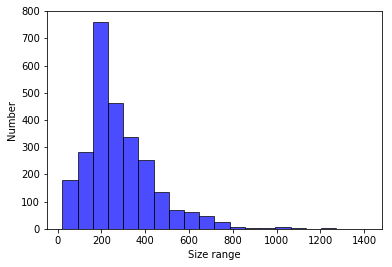

In [0]:
os.system('unzip img_benign.zip')
os.system('unzip img_genome.zip')

size_list = []
for filename in os.listdir(r"./img_benign/"):
  #print(filename)   
  img = cv2.imread('./img_benign/' + filename, 1)
  if img is None:
    continue
  
  size_list.append(img.shape[0])
  
for filename in os.listdir(r"./img_genome/"):
  #print(filename)   
  img = cv2.imread('./img_genome/' + filename, 1)
  if img is None:
    continue
    
  size_list.append(img.shape[0])
    
plt.figure()
plt.hist(size_list, bins=20, facecolor="blue", edgecolor="black", alpha=0.7)
plt.xlabel('Size range')
plt.ylabel('Number')
plt.show()

## Data preprocessing

### Read RGB images and normalize all those images

In [0]:
benign_img_list = []
for filename in os.listdir(r"./img_benign/"):
  #print(filename)   
  img = cv2.imread('./img_benign/' + filename, 1)
  if img is None:
    continue
  
  # resize to 300*300 size
  img = cv2.resize(img, (300, 300)) 
  # normalize to 0~1
  img = img / 255.0
  benign_img_list.append(img)

benign_img_list = np.array(benign_img_list)  
print(benign_img_list.shape)
benign_len = benign_img_list.shape[0]

(1386, 300, 300, 3)


In [0]:
genome_img_list = []
for filename in os.listdir(r"./img_genome/"):
  #print(filename)   
  img = cv2.imread('./img_genome/' + filename, 1)
  if img is None:
    continue
    
  img = cv2.resize(img, (300, 300)) 
  img = img / 255.0
  genome_img_list.append(img)

genome_img_list = np.array(genome_img_list)  
print(genome_img_list.shape)
genome_len = genome_img_list.shape[0]

(1260, 300, 300, 3)


### Split them to training and testing set

In [0]:
testing_set = np.concatenate((benign_img_list[1000:], genome_img_list[1000:]), axis=0)
print(testing_set.shape)

testing_label = np.array([0]*(benign_len-1000) + [1]*(genome_len-1000))

training_set = np.concatenate((benign_img_list[0:1000], genome_img_list[0:1000]), axis=0)
print(training_set.shape)

training_label = np.array([0]*1000 + [1]*1000)

del benign_img_list
del genome_img_list
gc.collect()

(646, 300, 300, 3)
(2000, 300, 300, 3)


209

### Shuffle the training set

In [0]:
order = np.argsort(np.random.random(training_label.shape[0]))
training_set[order]
training_label[order]
# print(training_label)

array([1, 0, 1, ..., 0, 1, 1])

In [0]:
# index = np.where(training_label==0)
# print(index)
# print(len(index[0]))

## Build the CNN model

### Functions to build the topology of CNN and plot the training history

In [0]:
def build_model(input_shape, optimizer):
  model = Sequential()
  model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=input_shape, activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(32, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(64, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())
  model.add(Dense(64))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  # model.add(Dense(2))
  # model.add(Activation('softmax'))
  model.add(Dense(1))
  model.add(Activation('sigmoid'))

  model.compile(loss='binary_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy']) 
  
  return model


Plot the training history, accuracy vs. epoch

In [0]:
def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('accuracy')
  plt.plot(history.epoch, np.array(history.history['acc']),
           label='Train Acc')
  plt.plot(history.epoch, np.array(history.history['val_acc']),
           label = 'Val Acc')
#   plt.plot(history.epoch, np.array(history.history['loss']),
#            label='Train Loss')
#   plt.plot(history.epoch, np.array(history.history['val_loss']),
#            label = 'Val loss')
  plt.legend()
  plt.ylim([0, 1])

In [0]:
def plot_comparison(history_sgd, history_adam, hisotry_rmsprop):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('accuracy')
#   plt.plot(history_sgd.epoch, np.array(history_sgd.history['acc']), label='SGD acc')
#   plt.plot(history_adam.epoch, np.array(history_adam.history['acc']), label='Adam acc')
#   plt.plot(history_rmsprop.epoch, np.array(history_rmsprop.history['acc']), label='RMSProp acc')

  plt.plot(history_sgd.epoch, np.array(history_sgd.history['val_acc']), label='SGD val_acc', linestyle='--')
  plt.plot(history_adam.epoch, np.array(history_adam.history['val_acc']), label='Adam val_acc', linestyle='--')
  plt.plot(history_rmsprop.epoch, np.array(history_rmsprop.history['val_acc']), label='RMSProp val_acc', linestyle='--')

  plt.legend()
  plt.ylim([0, 1])
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('accuracy')
  plt.plot(history_sgd.epoch, np.array(history_sgd.history['acc']), label='SGD acc')
  plt.plot(history_adam.epoch, np.array(history_adam.history['acc']), label='Adam acc')
  plt.plot(history_rmsprop.epoch, np.array(history_rmsprop.history['acc']), label='RMSProp acc')
  plt.legend()
  plt.ylim([0, 1])

### Train the CNN model
Set the upperbound of epochs which is 50 \\
Set the batch size as 16 \\
Set the early stop condition that once the accuracy of validation set stops increasing after 3 epochs, the training will terminate

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 1600 samples, validate on 400 samples
Epoch 1/50
1600/1600 [==============================] - 274s 171ms/step - loss: 1.0766 - acc: 0.6500 - val_loss: 0.6858 - val_acc: 0.6350
Epoch 2/50
1600/1600 [==============================] - 269s 168ms/step - loss: 0.5326 - acc: 0.7450 - val_loss: 0.5415 - val_acc: 0.7200
Epoch 3/50
1600/1600 [==============================] - 268s 167ms/step - loss: 0.4574 - acc: 0.8056 - val_loss: 0.6086 - val_acc: 0.6675
Epoch 4/50
1600/1600 [==============================] - 268s 168ms/step - loss: 0.3849 - acc: 0.8456 - val_loss: 0.4734 - val_acc: 0.7775
Epoch 5/50
1600/1600 [==============================] - 267s 167ms/step - loss: 0.3554 - acc: 0.8662 - val_loss: 0.6211 - val_acc: 0.7225
Epoch 6/50
1600/1600 [======

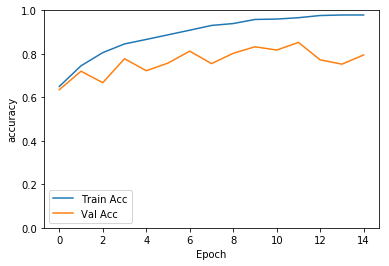

In [0]:
img_width, img_height = 300, 300

nb_train_samples = 2000
#nb_validation_samples = 800
epochs = 50
batch_size = 16

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

model = build_model(input_shape, 'rmsprop')

early_stop = keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, restore_best_weights=True)

history = model.fit(
    training_set,
    training_label,
    batch_size=batch_size, 
    epochs=epochs,
    validation_split=0.2,
    callbacks=[early_stop]
    )

plot_history(history)

### Compare the efficiency of SGD, Adam, and RMSProp optimizer

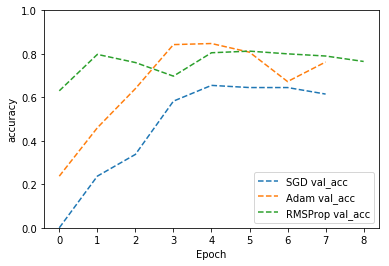

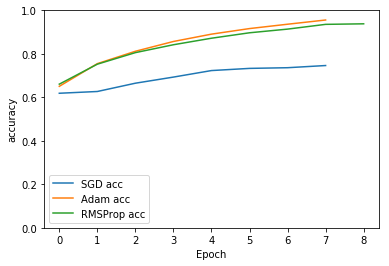

In [0]:
model_sgd = build_model(input_shape, 'sgd')
model_adam = build_model(input_shape, 'adam')
model_rmsprop = build_model(input_shape, 'rmsprop')

early_stop = keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, restore_best_weights=True)

history_sgd = model_sgd.fit(training_set, training_label, batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=[early_stop])
history_adam = model_adam.fit(training_set, training_label, batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=[early_stop])
history_rmsprop = model_rmsprop.fit(training_set, training_label, batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=[early_stop])

plot_comparison(history_sgd, history_adam, history_rmsprop)

In [0]:
# model.save('./model1.h5')
# plot_model(model, to_file='model.png')

## Evaluate the model and predict labels of testing set

In [0]:
model = keras.models.load_model('model1.h5')
loss, acc = model.evaluate(testing_set, testing_label)
print('The accuracy on testing set is %.2f.' % acc)

start = time.time()
predictions = model.predict(testing_set)
end = time.time()
average_prediction_time = (end - start) / len(predictions)
print('The average detection time is %.2fs.' % average_prediction_time)


predictions = np.around(predictions)
predictions = predictions.flatten()

### Calculate some metrics

In [0]:
len(predictions)

TP = np.sum(np.logical_and(predictions == 1, testing_label == 1))
TN = np.sum(np.logical_and(predictions == 0, testing_label == 0))
FP = np.sum(np.logical_and(predictions == 1, testing_label == 0))
FN = np.sum(np.logical_and(predictions == 0, testing_label == 1))
print('TP: %d, TN: %d, FP: %d, FN: %d' % (TP, TN, FP, FN))

precision = TP / (TP + FP)
recall = TP / (TP + FN)
fpr = (FP) / (FP + TN)
f1 = 2 * (precision*recall) / (precision+recall)
print('The precision is {:.1%}.'.format(precision))
print('The detection rate is {:.1%}.'.format(recall))
print('The accuracy is {:.1%}.'.format(acc))
print('The false positive rate is {:.1%}.'.format(fpr))
print('The F1-score is {:.1%}.'.format(f1))

print('The accuracy towards benign applications is {:.1%}'.format(TN / (TN + FP)))

TP: 217, TN: 337, FP: 49, FN: 43
The precision is 81.6%.
The detection rate is 83.5%.
The accuracy is 85.8%.
The false positive rate is 12.7%.
The F1-score is 82.5%.
The accuracy towards benign applications is 87.3%


### Predict labels of new unseen images

In [0]:
model = keras.models.load_model('model1.h5')
os.system('unzip new_set.zip')

256

In [0]:
new_img_list = []
for filename in os.listdir(r"./new_set/"):
  img = cv2.imread('./new_set/' + filename, 1)
  if img is None:
    continue
  
  # resize to 300*300 size
  img = cv2.resize(img, (300, 300)) 
  # normalize to 0~1
  img = img / 255.0
  new_img_list.append(img)

new_img_list = np.array(new_img_list)

print(new_img_list.shape)

new_pred = model.predict(new_img_list)
new_pred = np.around(new_pred)
print(new_pred)

(4, 300, 300, 3)
[[1.]
 [1.]
 [1.]
 [1.]]
